In [1]:
import pandas as pd
from Testmodule import 證交所產業分類, 資產負債表, 綜合損益表
from datetime import date

current_date = date.today()
user_year = current_date.year
current_quarter = (current_date.month - 1) // 3 + 1


if (   # 以金管會規定財報發佈期間為標準，若介於財報尚未發佈期間
    (date(current_date.year, 1, 1) <= current_date <= date(current_date.year, 3, 31)) or 
    (date(current_date.year, 4, 1) <= current_date <= date(current_date.year, 5, 15)) or
    (date(current_date.year, 7, 1) <= current_date <= date(current_date.year, 8, 14)) or
    (date(current_date.year, 10, 1) <= current_date <= date(current_date.year, 11, 14))
    ):
    
    # 改成抓上兩季的資料（如果現在是第一季，抓去年第三季資料）
    user_quarter = current_quarter- 2
    if user_quarter <= 0:
        user_quarter += 4
        user_year -= 1

else:
    user_quarter = current_quarter - 1 # 抓上一季的資料（如果現在是第一季，抓去年第三季）
    if user_quarter <= 0:
        user_quarter += 4
        user_year -= 1 

income_statement = 綜合損益表.綜合損益表by季(user_year, user_quarter)
balance_sheet = 資產負債表.資產負債表by季(user_year, user_quarter)

   
#兩張table都有獨立的key，利用這兩個key值將兩張table結合
resultdf = income_statement.merge(balance_sheet,on='Key',how='inner')
resultdf = resultdf.drop(columns=['公司 代號_y', '年度_y', '季別_y', '公司名稱_y']) #刪掉重複欄位
resultdf.rename(columns = {'公司 代號_x':'公司代號', '年度_x':'年度', '季別_x':'季別', '公司名稱_x':'公司名稱' }, inplace = True)
resultdf['公司代號'] = resultdf['公司代號'].astype(str) #變更欄位的type，用於merge用
category = 證交所產業分類.industry()
resultdf = resultdf.merge(category,how = "inner",on = "公司代號")
resultdf


,公司代號,年度,季別,公司名稱,營業收入,營業成本,原始認列生物資產及農產品之利益（損失）,生物資產當期公允價值減出售成本之變動利益（損失）,營業毛利（毛損）,未實現銷貨（損）益,...,歸屬於母公司業主之權益合計,共同控制下前手權益,合併前非屬共同控制股權,非控制權益,權益總計,待註銷股本股數（單位：股）,預收股款（權益項下）之約當發行股數（單位：股）,母公司暨子公司所持有之母公司庫藏股股數（單位：股）,每股參考淨值,產業別
0,1101,112,3,台泥,80966464,66737333,--,--,14229131,--,...,222398369,--,--,22328122,244726491,--,0,20000000,30.32,水泥工業
1,1101,112,2,台泥,53964171,45509992,--,--,8454179,--,...,214284220,--,--,20435231,234719451,--,0,20000000,29.21,水泥工業
2,1101,112,1,台泥,26295929,23826708,--,--,2469221,--,...,220077058,--,--,20003976,240081034,--,0,24000000,30.02,水泥工業
3,1101,111,4,台泥,113929706,104345739,--,--,9583967,--,...,217894766,--,--,20381014,238275780,--,0,4000000,29.64,水泥工業
4,1101,111,3,台泥,79274330,74872991,--,--,4401339,--,...,201413996,--,--,20256450,221670446,--,0,4000000,29.05,水泥工業
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4767,9958,112,3,世紀鋼,9539392,8275189,--,--,1264203,--,...,7895925,--,--,3434276,11330201,--,0,0,33.59,鋼鐵工業
4768,9958,112,2,世紀鋼,5894102,5299030,--,--,595072,--,...,7354916,--,--,3214123,10569039,--,0,0,31.53,鋼鐵工業
4769,9958,112,1,世紀鋼,2675284,2510328,--,--,164956,--,...,6966880,--,--,3226055,10192935,--,0,0,29.98,鋼鐵工業
4770,9958,111,4,世紀鋼,9222058,8779554,--,--,442504,--,...,6959252,--,--,3281807,10241059,--,0,0,29.95,鋼鐵工業


In [2]:
# dataset1
# 把resultdf另外用project這個dictionary給複製出來，避免改動到原始爬蟲資料
project = {}
project['公司代號'] = resultdf['公司代號']
project['公司名稱'] = resultdf['公司名稱']
project['產業別'] = resultdf['產業別']
project['年度'] = resultdf['年度'] 
project['季別'] = resultdf['季別']
project['基本每股盈餘_EPS'] = resultdf['基本每股盈餘（元）'] #EPS(1)
project['營業收入'] = resultdf['營業收入']
project['本期淨利（淨損）'] = resultdf['本期淨利（淨損）'] #利潤(6)

project = pd.DataFrame(project)


In [3]:
# dataset1
import pandas as pd
from pandas.core.reshape.pivot import pivot
# 先將project的年度、季別合併，變成date的形式後排序，之後繪圖座標軸才會正確
project['Date'] = (project['年度'] + 1911).astype(str)+ (project['季別']*3-2).astype(str)
project['Date'] = pd.to_datetime(project['Date'], format='%Y%m')

import datetime
p_time = project #複製一個要修改的p_time避免動到原本project
p_time = p_time.drop_duplicates(subset=['Date']) #把重複的時間刪掉，因此只會有5個時間從最新(當季)到最舊(前5季)
time_list = []
for i in range(5):
    time_list.append(p_time.iat[i,-1].strftime("%Y-%m-%d")) #用for迴圈把每個時間加到time_list
time_list = sorted(time_list, reverse=True) #由最新的季別排到最早的季別

# 處理missing
project1 = project.dropna(subset=['基本每股盈餘_EPS','營業收入', '本期淨利（淨損）']) #n=4772
project1 = project1.groupby(['公司名稱']).agg('count') #n=958
project1 = project1[~(project1['基本每股盈餘_EPS'] < 5)] #n=943
project1 = pd.merge(project1, project, how = 'left', suffixes=["_x",""], on = ['公司名稱']) #n=4715
project1 = project1[['產業別','公司代號','公司名稱','基本每股盈餘_EPS','營業收入', '本期淨利（淨損）','Date','季別','年度']] #n=4715
project1

# exclude1: 2023/Q3>2022/Q3 營收
p1 = project1[['公司名稱','Date','營業收入']]
p1.sort_values(by = ['公司名稱','Date'],) #排序資料
p1 = p1.pivot(index = '公司名稱',columns = 'Date',values = '營業收入') #轉置表格 #n=943
p1 = p1[~(p1[time_list[0]] < p1[time_list[4]])] #n=319
p1 = pd.merge(p1, project1, how = 'left', on = ['公司名稱']) #n=1595
p1 = p1[['產業別','公司代號','公司名稱','基本每股盈餘_EPS','營業收入', '本期淨利（淨損）','Date']] #n=1595


# exclude2 : 任一季EPS為負數
p2 = p1[['公司名稱','Date','基本每股盈餘_EPS']]
p2.sort_values(by = ['公司名稱','Date'])
p2 = p2.pivot(index = '公司名稱',columns = 'Date',values = '基本每股盈餘_EPS') #n=319
for time_ymd in time_list:
    p2 = p2[~(p2[time_ymd] < 0)] #n=233 用迴圈跑time_list取代固定季別，之後可以擴充更多季別
p2 = pd.merge(p2, project, how = 'left', on = ['公司名稱'])
p2 = p2[['產業別','公司代號','公司名稱','基本每股盈餘_EPS','營業收入', '本期淨利（淨損）','Date']] #n=1165

# exclude3: 2023/Q3>2022/Q3 利潤
p3 = p2[['公司名稱','Date','本期淨利（淨損）']]
p3.sort_values(by = ['公司名稱','Date']) #排序資料
p3 = p3.pivot(index = '公司名稱',columns = 'Date',values = '本期淨利（淨損）') #轉置表格 #n=233
p3 = p3[~(p3[time_list[0]] < p3[time_list[4]])] #n=167
p3 = pd.merge(p3, project1, how = 'left', on = ['公司名稱'])
p3 = p3[['產業別','公司代號','公司名稱','基本每股盈餘_EPS','營業收入', '本期淨利（淨損）','Date']] #n=4710

#篩選出年收成長前5%支
p3['公司代號+公司名稱']=p3['公司代號']+" "+p3['公司名稱']
dataset1 = p3.pivot(index = ['公司代號+公司名稱'],columns = 'Date',values = '營業收入')
dataset1['季營收成長率(%)'] = round(((dataset1[time_list[0]]-dataset1[time_list[4]])/dataset1[time_list[4]])*100,2)
dataset1.sort_values(by = ['季營收成長率(%)'], ascending=False,inplace=True) #排序資料) #排序資料
dataset1 = dataset1.head(int((len(dataset1.axes[0])-1)*0.05)) #n=8
output1=""
for i in dataset1.index.values:
    output1 += str(i)+"\n"

print(output1)


2542 興富發
1529 樂事綠能
4763 材料-KY
3661 世芯-KY
6806 森崴能源
6472 保瑞
8996 高力
3257 虹冠電



In [4]:
# dataset2，使用者自行選擇產業，之後依ROE排序列印出來
dataset2 = resultdf
industry_list = [str(i)for i in list(set(dataset2['產業別'])) if i]

In [5]:
# dataset2
# 把產業別印出來，讓使用者選
print(industry_list)

# 先篩選出產業，直到輸入正確的產業
while True:
    try:
        industry_input = str(input('請輸入產業：'))
        if industry_input in industry_list:
            break
    except:
        print('輸入錯誤')
        continue

#以下為計算Data clearing----------------------------------------------------------------------------
    
# 先按公司、年度、季別排序 
dataset2 = dataset2.sort_values(by=['公司代號', '年度', '季別'])

# 將季別轉換為數值
dataset2['季別'] = pd.to_numeric(dataset2['季別'])

# 計算當季與前一季權益、資產的平均
dataset2['權益_avg'] = (dataset2['權益總計'] + dataset2.groupby('公司代號')['權益總計'].shift(1)) / 2
dataset2['資產_avg'] = (dataset2['資產總計'] + dataset2.groupby('公司代號')['資產總計'].shift(1)) / 2

# 計算當季淨利
dataset2['本期淨利_diff'] = dataset2['本期淨利（淨損）']
# 如果不是第一季，計算與前一季差異
mark = dataset2['季別'] != 1
dataset2.loc[mark, '本期淨利_diff'] = dataset2.groupby('公司代號')['本期淨利（淨損）'].diff()

# 計算營業收入
dataset2['本期營收_diff'] = dataset2['營業收入']
# 如果不是第一季，計算與前一季差異
mark = dataset2['季別'] != 1
dataset2.loc[mark, '本期營收_diff'] = dataset2.groupby('公司代號')['營業收入'].diff()


#--------------------------------------------------------------------------------------------------


['鋼鐵工業', '居家生活', '玻璃陶瓷', '光電業', '橡膠工業', '水泥工業', '油電燃氣業', '電子零組件業', '電機機械', '食品工業', '建材營造業', '運動休閒', '半導體業', '塑膠工業', '電腦及週邊設備業', '其他業', '汽車工業', '紡織纖維', '其他電子業', '通信網路業', '綠能環保', '造紙工業', '資訊服務業', '觀光餐旅', '電子通路業', '貿易百貨業', '數位雲端', '航運業', '生技醫療業', '電器電纜', '化學工業']


In [7]:
# dataset2
# 根據使用者選擇的產業來篩選
filtered_data = dataset2[dataset2['產業別'] == industry_input]

# 計算各個比率
filtered_data['ROE'] = filtered_data['本期淨利_diff'] / filtered_data['權益_avg']
if 'ROE' in filtered_data.columns:
    filtered_data = filtered_data[filtered_data['ROE'].notna()] #將ROE是NA值拿掉

filtered_data['淨利率'] = filtered_data['本期淨利_diff'] / filtered_data['本期營收_diff']
if '淨利率' in filtered_data.columns:
    filtered_data = filtered_data[filtered_data['淨利率'].notna()] #將淨利率是NA值拿掉

filtered_data['權益乘數'] = filtered_data['資產總計'] / filtered_data['權益總計']
if '權益乘數' in filtered_data.columns:
    filtered_data = filtered_data[filtered_data['權益乘數'].notna()] #將權益乘數是NA值拿掉

filtered_data['總資產週轉率'] = filtered_data['本期營收_diff'] / filtered_data['資產總計']
if '總資產週轉率' in filtered_data.columns:
    filtered_data = filtered_data[filtered_data['總資產週轉率'].notna()] #將總資產週轉率是NA值拿掉


company_list = {}
for code, name in zip(filtered_data['公司代號'],filtered_data['公司名稱']):
    company_list[code] = name

print(list(company_list.keys()))
print(list(company_list.values()))

# 讓使用者輸入想要知道的公司名稱或股票代碼:
while True:
    try:
        company_input = str(input('請輸入公司名稱或股票代碼：'))
        if company_input in company_list.keys() or company_input in company_list.values():
            break
    except:
        print('輸入錯誤')
        continue
    
if company_input.isdigit():
    filtered_data = filtered_data[filtered_data['公司代號'] == company_input]
else:
    filtered_data = filtered_data[filtered_data['公司名稱'] == company_input]

filtered_data['ROE'] = filtered_data['ROE']*100
filtered_data['淨利率'] = filtered_data['淨利率']*100


C:\Users\hp\AppData\Local\Temp\ipykernel_17204\1709265953.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['ROE'] = filtered_data['本期淨利_diff'] / filtered_data['權益_avg']


['2002', '2006', '2007', '2008', '2009', '2010', '2012', '2013', '2014', '2015', '2017', '2020', '2022', '2023', '2024', '2025', '2027', '2028', '2029', '2030', '2031', '2032', '2033', '2034', '2038', '2069', '2211', '3004', '5007', '5538', '9958']
['中鋼', '東和鋼鐵', '燁興', '高興昌', '第一銅', '春源', '春雨', '中鋼構', '中鴻', '豐興', '官田鋼', '美亞', '聚亨', '燁輝', '志聯', '千興', '大成鋼', '威致', '盛餘', '彰源', '新光鋼', '新鋼', '佳大', '允強', '海光', '運錩', '長榮鋼', '豐達科', '三星', '東明-KY', '世紀鋼']


In [8]:
# dataset2
# 判斷使用者使用環境
from sys import platform
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt

if platform == 'darwin':
    # 設定中文字體
    plt.rcParams['font.family'] = 'Arial Unicode MS'  # 使用 macOS 的內建中文字體

    # 使用中文字體
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
    plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題

elif platform == 'win32':
    # 設定字體路徑
    font_path = r'C:\Windows\Fonts'  # 改為電腦內建的字體

    # 設定字體
    custom_font = FontProperties(fname=font_path)

    # 使用中文字體
    plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 替換為你選擇的繁體中文字體
    plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題


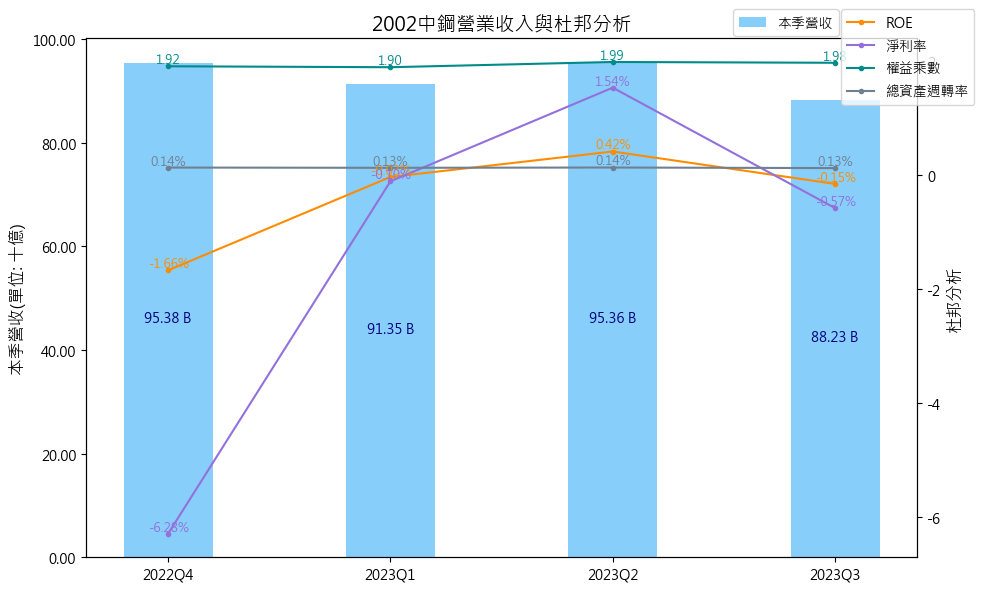

In [9]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter

# Combine '年度' and '季別' as a categorical variable
time_series = {}
time_series['年度'] = filtered_data['年度'] + 1911 # Add 1911 to convert to Western calendar year
time_series['年度季別'] = time_series['年度'].astype(str) + 'Q' + filtered_data['季別'].astype(str)

# Create a bar plot and line plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# 畫'營業收入'柱狀圖
bars = ax1.bar(time_series['年度季別'], filtered_data['本期營收_diff'], color='lightskyblue', label='本季營收', width = 0.4)
ax1.set_ylabel('本季營收(單位: 十億)', fontsize=12)
ax1.tick_params(axis='x')

# 顯示每季'營業收入'數字
for bar, value in zip(bars, filtered_data['本期營收_diff']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height()/2, f'{value/1000000:.2f} B',
             ha='center', va='top', fontsize=10, color='navy')

# 畫'杜邦分析'折線圖
ax2 = ax1.twinx()
line1 = ax2.plot(time_series['年度季別'], filtered_data['ROE'], color='darkorange', marker='o',markersize=3, label='ROE')[0]
line2 = ax2.plot(time_series['年度季別'], filtered_data['淨利率'], color='mediumpurple', marker='o',markersize=3, label='淨利率')[0]
line3 = ax2.plot(time_series['年度季別'], filtered_data['權益乘數'], color='darkcyan', marker='o',markersize=3, label='權益乘數')[0]
line4 = ax2.plot(time_series['年度季別'], filtered_data['總資產週轉率'], color='slategrey', marker='o',markersize=3, label='總資產週轉率')[0]
ax2.set_ylabel('杜邦分析', fontsize=12)

# 顯示每季'杜邦分析'數字
for x, y in zip(time_series['年度季別'], filtered_data['ROE']):
    plt.text(x, y, f'{y:.2f}%', ha='center', va='bottom', fontsize=9, color='darkorange')
for x, y in zip(time_series['年度季別'], filtered_data['淨利率']):
    plt.text(x, y, f'{y:.2f}%', ha='center', va='bottom', fontsize=9, color='mediumpurple')
for x, y in zip(time_series['年度季別'], filtered_data['權益乘數']):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom', fontsize=9, color='darkcyan')
for x, y in zip(time_series['年度季別'], filtered_data['總資產週轉率']):
    plt.text(x, y, f'{y:.2f}%', ha='center', va='bottom', fontsize=9, color='slategrey')

legend1 = ax1.legend(loc='upper left', bbox_to_anchor=(0.77, 1.07))
legend2 = ax2.legend(loc='upper left', bbox_to_anchor=(0.9, 1.07))

ax1.get_yaxis().set_major_formatter(FuncFormatter(lambda x, _: f'{x/1000000:.2f}'))

# 設定標題
try:
    plt.title(f'{company_input}{company_list[company_input]}營業收入與杜邦分析', fontsize=14)
except:
    plt.title(f'{[key for key, value in company_list.items() if value == company_input][0]}{company_input}營業收入與杜邦分析', fontsize=14)

plt.tight_layout()

plt.xticks(fontsize=10)
plt.show()


In [10]:
try:
    print(f'{company_input}{company_list[company_input]}')
except:
    print(f'{[key for key, value in company_list.items() if value == company_input][0]}{company_input}')

print('過去四季營業收入:')
for revenue, year, quarter in zip(filtered_data['本期營收_diff'], filtered_data['年度'], filtered_data['季別']):
    print(f'{year+1911}第{quarter}季:{round(revenue/100000,2)}億台幣')

print('')
print('過去四季ROE:')
for roe, year, quarter in zip(filtered_data['ROE'], filtered_data['年度'], filtered_data['季別']):
    print(f'{year+1911}第{quarter}季:{round(roe,2)}%')


2002中鋼
過去四季營業收入:
2022第4季:953.77億台幣
2023第1季:913.46億台幣
2023第2季:953.57億台幣
2023第3季:882.29億台幣

過去四季ROE:
2022第4季:-1.66%
2023第1季:-0.03%
2023第2季:0.42%
2023第3季:-0.15%
